In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys
import random

In [10]:
df = pd.read_csv("dataset/resize_borvo.csv") 

grid = {}
for _, row in df.iterrows():
    grid[(int(row["i"]), int(row["j"]))] = {"H": row["H"], "W": row["W"]}

In [11]:
# Fungsi ambil tetangga 8 arah (termasuk diagonal)
def get_all_neighbors(pos):
    i, j = pos
    directions = [
        (-1, -1), (-1, 0), (-1, 1),
        (0, -1),           (0, 1),
        (1, -1), (1, 0), (1, 1)
    ]
    neighbors = [(i + di, j + dj) for di, dj in directions]
    return [n for n in neighbors if n in grid]

# Fungsi hitung skor W/E
def get_score(current_pos, neighbor_pos):
    H1 = grid[current_pos]["H"]
    H2 = grid[neighbor_pos]["H"]
    S = H1 - H2

    if S > 0.5:
        return -np.inf  # Tidak aman → skip

    E = 1 + 1 * abs(S)
    W = grid[neighbor_pos]["W"]
    return W / E

In [12]:
def get_state_quality(node):
    kualitas = grid[node]["H"] - (0.5 * grid[node]["W"])
    return kualitas
def simulated_annealing_standard(start, Tmax=1000, Tmin=1.0, alpha=0.95, max_iter=1000):
    """
    Versi SA yang lebih standar, membandingkan kualitas state.
    """
    if start not in grid:
        print(f"Titik {start} tidak ditemukan dalam dataset.")
        return [], []

    current_pos = start
    path = [current_pos]
    
    # Untuk grafik, kita akan plot kualitas dari setiap state/titik di jalur
    performance_data = [get_state_quality(current_pos)]

    current_quality = get_state_quality(current_pos)
    T = Tmax

    for _ in range(max_iter):
        if T < Tmin:
            break

        # Pilih tetangga secara acak
        valid_neighbors = [n for n in get_all_neighbors(current_pos) if n not in path]
        if not valid_neighbors:
            break
        
        next_pos = random.choice(valid_neighbors)
        
        # Cek apakah langkah ke tetangga aman (menggunakan fungsi get_score lama Anda)
        safety_check_score = get_score(current_pos, next_pos)
        if safety_check_score == -np.inf:
            continue

        # Hitung perbedaan kualitas antara state baru dan state lama
        next_quality = get_state_quality(next_pos)
        delta_quality = next_quality - current_quality

        # Kriteria penerimaan Metropolis
        if delta_quality > 0: # Jika langkah baru lebih baik, selalu terima
            current_pos = next_pos
            current_quality = next_quality
            path.append(current_pos)
            performance_data.append(current_quality)
        elif random.random() < np.exp(delta_quality / T): # Jika lebih buruk, terima dengan probabilitas
            current_pos = next_pos
            current_quality = next_quality
            path.append(current_pos)
            performance_data.append(current_quality)
        
        # Dinginkan temperatur
        T *= alpha

    return path, performance_data

In [13]:
# Titik uji coba
test_points = [
    (540/2, 648/2),
    (20/2, 502/2),
    (410//2, 915//2),
    (529, 357)
]

# Jalankan algoritma untuk semua titik uji
for idx, point in enumerate(test_points, 1):
    print(f"\n=== Titik {idx} - Start di {point} ===")
    path = simulated_annealing_standard(point)
    print(f"Jumlah langkah: {len(path)}")
    print("Jalur:")
    for p in path:
        print(p)


=== Titik 1 - Start di (270.0, 324.0) ===
Jumlah langkah: 2
Jalur:
[(270.0, 324.0), (269.0, 324.0), (268.0, 323.0), (268.0, 324.0), (269.0, 323.0), (268.0, 322.0), (269.0, 321.0), (269.0, 320.0), (269.0, 319.0), (270.0, 318.0), (271.0, 319.0), (271.0, 320.0), (270.0, 320.0), (270.0, 321.0), (270.0, 322.0), (271.0, 321.0), (272.0, 322.0), (273.0, 322.0), (272.0, 321.0), (273.0, 321.0), (274.0, 321.0), (275.0, 321.0), (274.0, 322.0), (274.0, 323.0), (275.0, 322.0), (276.0, 322.0), (277.0, 323.0), (277.0, 322.0), (276.0, 321.0), (276.0, 320.0), (275.0, 320.0), (276.0, 319.0), (277.0, 318.0), (277.0, 317.0), (276.0, 318.0), (277.0, 319.0), (277.0, 320.0), (278.0, 320.0), (279.0, 320.0), (280.0, 319.0), (280.0, 318.0), (279.0, 319.0), (278.0, 319.0), (278.0, 318.0), (279.0, 318.0), (279.0, 317.0), (280.0, 317.0), (281.0, 316.0), (282.0, 315.0), (283.0, 314.0), (282.0, 313.0), (283.0, 313.0), (284.0, 314.0), (283.0, 315.0), (282.0, 314.0), (281.0, 313.0), (280.0, 312.0), (279.0, 313.0), (27

1. Menjalankan algoritma Hill Climbing...
2. Algoritma selesai. Ditemukan jalur dengan 21 langkah.
3. Menyiapkan 'panggung' untuk rendering animasi...
4. Memulai proses rendering animasi ke file. Ini mungkin butuh waktu...
   ...merender frame 0/21
   ...merender frame 0/21


C:\Users\Rhama\AppData\Local\Temp\ipykernel_25912\2942104648.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  posisi_robot.set_data(koordinat_j[-1], koordinat_i[-1])


   ...merender frame 20/21

############################################################
###   BERHASIL! Animasi telah disimpan sebagai 'simulasi_robot SA ke 1.gif'   ###
###   Silakan buka file tersebut untuk melihat hasilnya.            ###
############################################################
1. Menjalankan algoritma Hill Climbing...
2. Algoritma selesai. Ditemukan jalur dengan 33 langkah.
3. Menyiapkan 'panggung' untuk rendering animasi...
4. Memulai proses rendering animasi ke file. Ini mungkin butuh waktu...
   ...merender frame 0/33
   ...merender frame 0/33


C:\Users\Rhama\AppData\Local\Temp\ipykernel_25912\2942104648.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  posisi_robot.set_data(koordinat_j[-1], koordinat_i[-1])


   ...merender frame 20/33

############################################################
###   BERHASIL! Animasi telah disimpan sebagai 'simulasi_robot SA ke 2.gif'   ###
###   Silakan buka file tersebut untuk melihat hasilnya.            ###
############################################################
1. Menjalankan algoritma Hill Climbing...
2. Algoritma selesai. Ditemukan jalur dengan 132 langkah.
3. Menyiapkan 'panggung' untuk rendering animasi...
4. Memulai proses rendering animasi ke file. Ini mungkin butuh waktu...
   ...merender frame 0/132
   ...merender frame 0/132


C:\Users\Rhama\AppData\Local\Temp\ipykernel_25912\2942104648.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  posisi_robot.set_data(koordinat_j[-1], koordinat_i[-1])


   ...merender frame 20/132
   ...merender frame 40/132
   ...merender frame 60/132
   ...merender frame 80/132
   ...merender frame 100/132
   ...merender frame 120/132

############################################################
###   BERHASIL! Animasi telah disimpan sebagai 'simulasi_robot SA ke 3.gif'   ###
###   Silakan buka file tersebut untuk melihat hasilnya.            ###
############################################################
1. Menjalankan algoritma Hill Climbing...
Titik (529, 357) tidak ditemukan dalam dataset.
!!! ALGORITMA HANYA MENGHASILKAN 0 TITIK. TIDAK CUKUP UNTUK MEMBUAT ANIMASI.


SystemExit: 

c:\Users\Rhama\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


   ...merender frame 0/0
Error in callback <function _draw_all_if_interactive at 0x0000022DB96796C0> (for post_execute), with arguments args (),kwargs {}:


IndexError: list index out of range

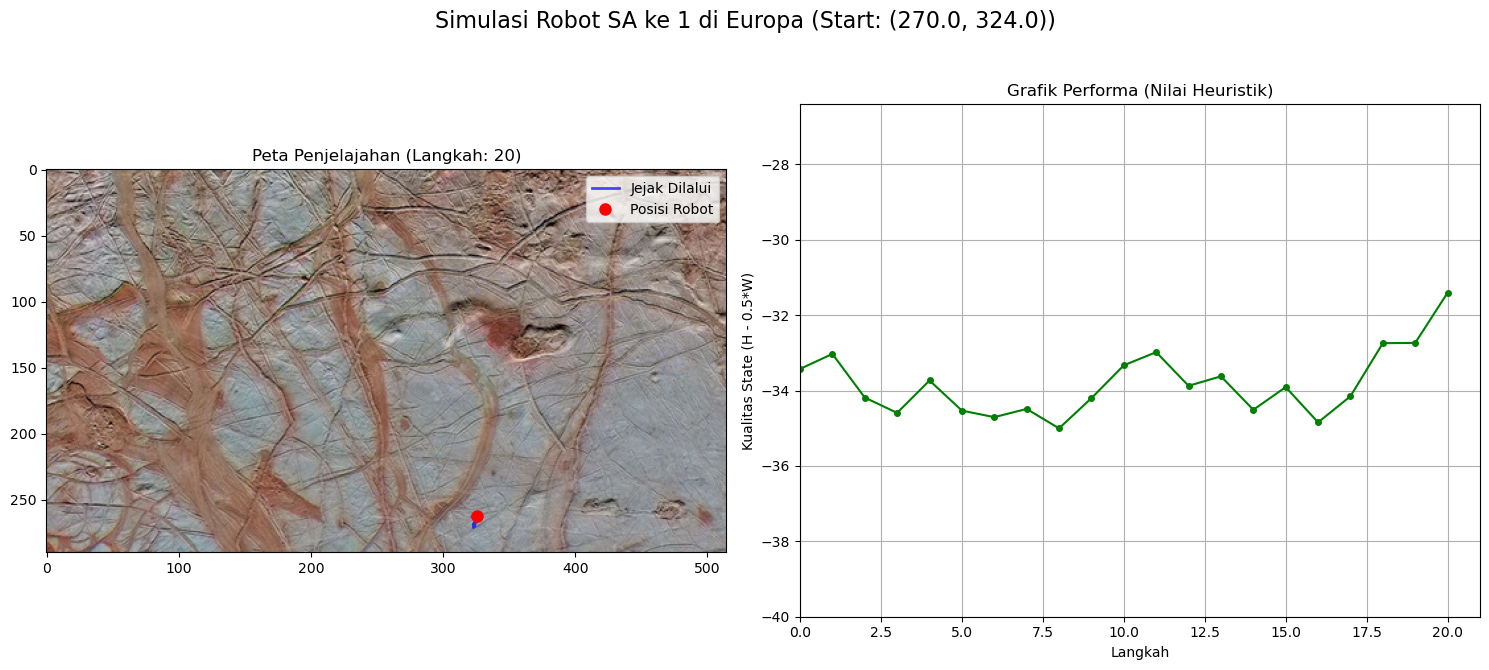

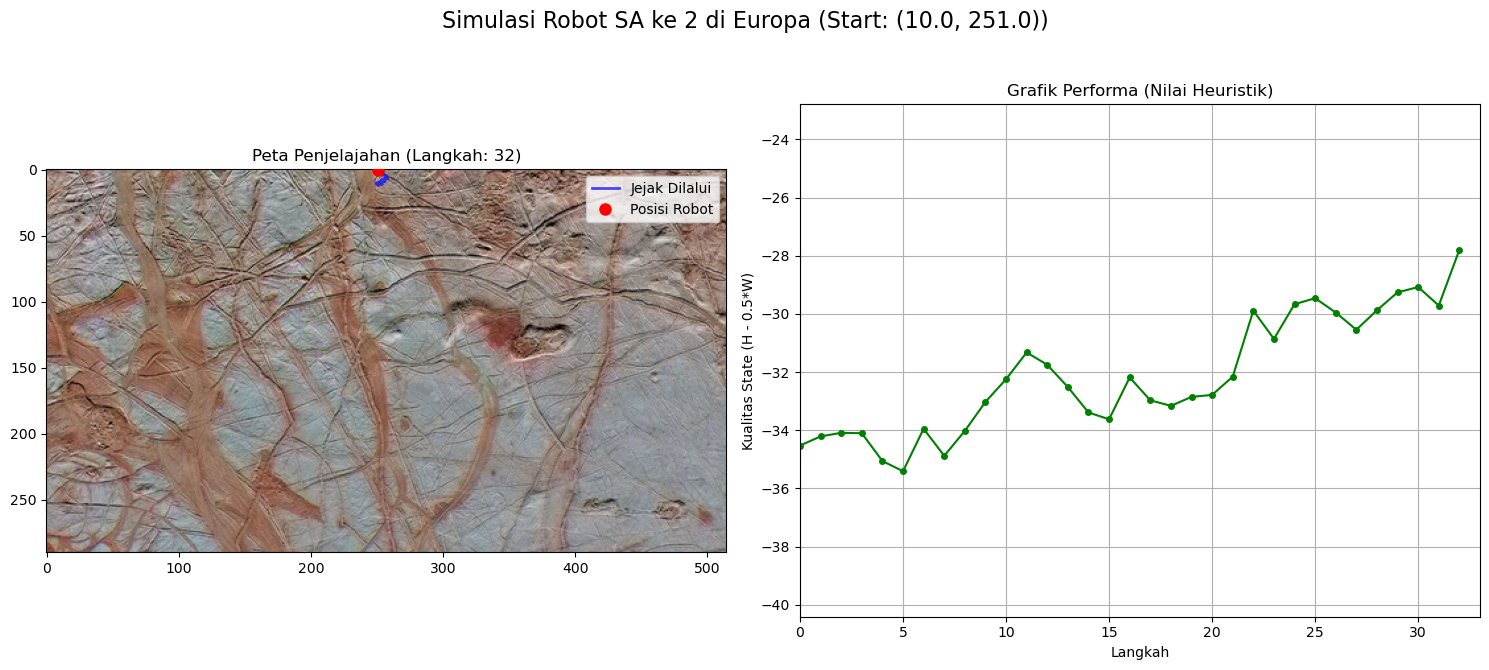

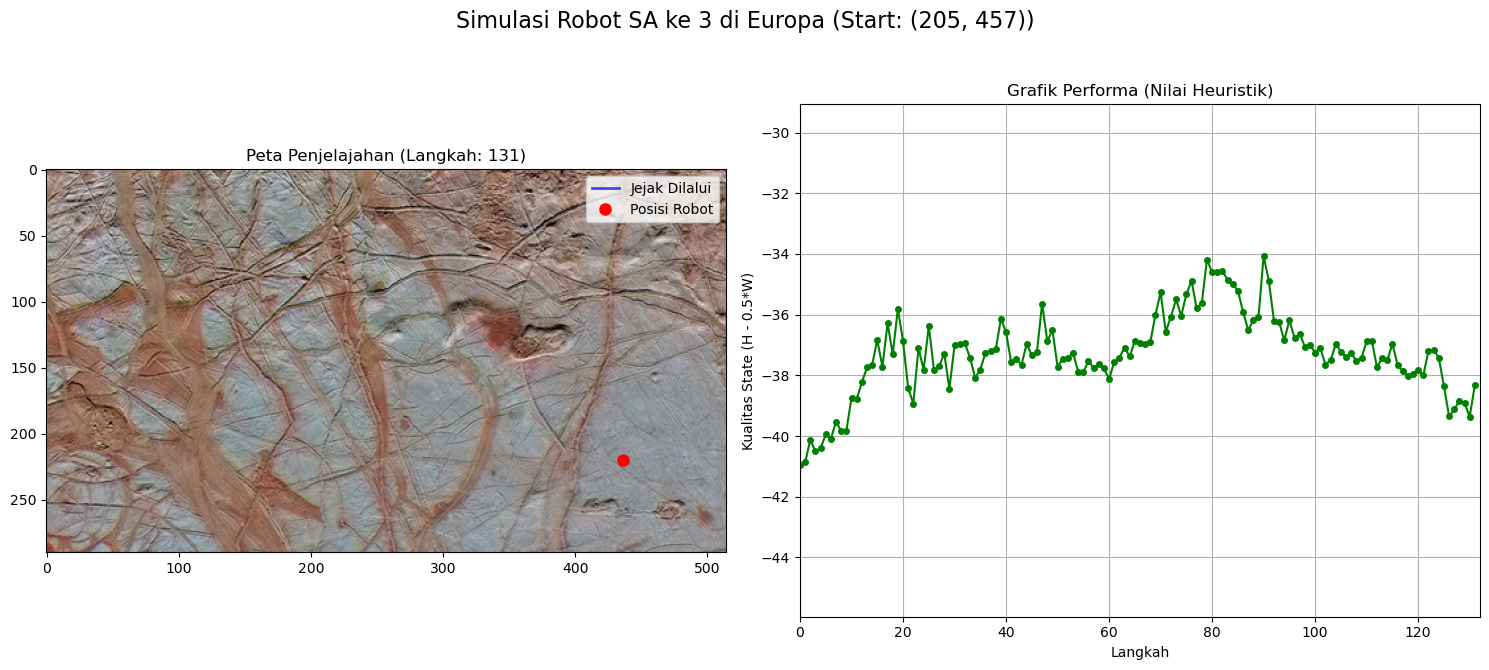

In [14]:

# =====================================================================
# --- BAGIAN 1: KONFIGURASI SIMULASI ---
# =====================================================================
# Atur titik awal dan parameter lainnya di sini
for idx,point in enumerate(test_points,1):
    titik_awal = point
    nama_file_peta = 'europa_map/raw/resize_borvo_mensa.jpg'
    nama_file_output = f'simulasi_robot SA ke {idx}.gif'

    # =====================================================================
    # --- BAGIAN 2: PERSIAPAN DATA ---
    # =====================================================================
    print("1. Menjalankan algoritma Hill Climbing...")
    try:
        jalur, data_performa = simulated_annealing_standard(titik_awal)
    except Exception as e:
        print(f"!!! TERJADI ERROR SAAT MENJALANKAN ALGORITMA: {e}")
        sys.exit() # Hentikan program jika algoritma error

    if not jalur or len(jalur) < 2:
        print(f"!!! ALGORITMA HANYA MENGHASILKAN {len(jalur)} TITIK. TIDAK CUKUP UNTUK MEMBUAT ANIMASI.")
        sys.exit()

    print(f"2. Algoritma selesai. Ditemukan jalur dengan {len(jalur)} langkah.")
    langkah_total = range(len(jalur))

    # =====================================================================
    # --- BAGIAN 3: PERSIAPAN PLOT (TIDAK AKAN DITAMPILKAN LIVE) ---
    # =====================================================================
    print("3. Menyiapkan 'panggung' untuk rendering animasi...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle(f'Simulasi Robot SA ke {idx} di Europa (Start: {titik_awal})', fontsize=16)

    try:
        img = plt.imread(nama_file_peta)
        ax1.imshow(img)
    except FileNotFoundError:
        ax1.set_facecolor('black')

    jejak_robot, = ax1.plot([], [], 'b-', lw=2, alpha=0.7, label='Jejak Dilalui', zorder=5)
    posisi_robot, = ax1.plot([], [], 'ro', ms=8, label='Posisi Robot', zorder=10) 
    ax1.legend()

    ax2.set_title('Grafik Performa (Nilai Heuristik)')
    ax2.set_xlabel('Langkah')
    ax2.set_ylabel('Kualitas State (H - 0.5*W)')
    ax2.set_xlim(0, len(jalur))
    if data_performa:
        ax2.set_ylim(min(data_performa) - 5, max(data_performa) + 5)
    ax2.grid(True)
    grafik_performa, = ax2.plot([], [], 'g-', marker='o', ms=4)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # =====================================================================
    # --- BAGIAN 4: FUNGSI UPDATE (UNTUK RENDERING) ---
    # =====================================================================
    def update(frame):
        if frame % 20 == 0:
            print(f"   ...merender frame {frame}/{len(jalur)}")
        
        path_sejauh_ini = jalur[:frame+1]
        koordinat_j = [titik[1] for titik in path_sejauh_ini]
        koordinat_i = [titik[0] for titik in path_sejauh_ini]
        
        jejak_robot.set_data(koordinat_j, koordinat_i)
        posisi_robot.set_data(koordinat_j[-1], koordinat_i[-1])
        grafik_performa.set_data(langkah_total[:frame+1], data_performa[:frame+1])
        ax1.set_title(f'Peta Penjelajahan (Langkah: {frame})')
        return jejak_robot, posisi_robot, grafik_performa,

    # =====================================================================
    # --- BAGIAN 5: RENDER DAN SIMPAN KE FILE ---
    # =====================================================================
    print("4. Memulai proses rendering animasi ke file. Ini mungkin butuh waktu...")
    ani = animation.FuncAnimation(fig, update, frames=len(jalur), blit=False)

    try:
        # fps = frame per second. Mengatur seberapa cepat animasi akan diputar.
        ani.save(nama_file_output, writer='pillow', fps=20)
        
        print("\n" + "#"*60)
        print(f"###   BERHASIL! Animasi telah disimpan sebagai '{nama_file_output}'   ###")
        print("###   Silakan buka file tersebut untuk melihat hasilnya.            ###")
        print("#"*60)

    except Exception as e:
        print(f"\n!!! GAGAL MENYIMPAN ANIMASI: {e}")